### Testing ML Models Without Applying PCA

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import uniform, randint

# Load the data
data = pd.read_csv('/Users/skyler/Documents/HR_Project/Data/raw_data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Convert categorical variables to numerical
data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})

# Select potentially relevant features based on domain knowledge
relevant_features = [
    'Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
    'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
    'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
    'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
    'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

# Select only the relevant features
X = data[relevant_features]
y = data['Attrition']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Calculate correlation with the target variable
correlation = X.corrwith(y)
print("Correlation with Attrition:")
print(correlation.sort_values(ascending=False))

# Select features with absolute correlation greater than 0.05
selected_features = correlation[abs(correlation) > 0.05].index.tolist()

print("\nSelected features:")
print(selected_features)

X = X[selected_features]

# Check class balance
print("\nClass balance:")
print(y.value_counts(normalize=True))

# Use SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the models with their hyperparameter distributions
models = {
    'Logistic Regression': (LogisticRegression(), {
        'C': uniform(0.001, 100),
        'penalty': ['l1', 'l2']
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5)
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': randint(100, 301),
        'max_depth': randint(3, 8),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5)
    }),
    'SVM': (SVC(), {
        'C': uniform(0.1, 10),
        'kernel': ['rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': randint(3, 10),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': randint(100, 301),
        'learning_rate': uniform(0.01, 0.19),
        'max_depth': randint(3, 8)
    }),
    'Neural Network': (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['tanh', 'relu'],
        'alpha': uniform(0.0001, 0.0099)
    }),
    'Naive Bayes': (GaussianNB(), {
        'var_smoothing': uniform(1e-10, 1e-8)
    })
}

# Perform random search for each model
best_models = {}
for name, (model, param_dist) in models.items():
    print(f"\nPerforming RandomizedSearchCV for {name}...")
    random_search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train_scaled, y_train)
    best_models[name] = random_search.best_estimator_
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Evaluate the best models on the test set
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# Find the best overall model
best_model_name = max(best_models, key=lambda name: accuracy_score(y_test, best_models[name].predict(X_test_scaled)))
best_model = best_models[best_model_name]

print(f"\nBest overall model: {best_model_name}")
print(f"Best model parameters: {best_model.get_params()}")
y_pred_best = best_model.predict(X_test_scaled)
print(f"Best model accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(classification_report(y_test, y_pred_best))

Correlation with Attrition:
OverTime_Yes                         0.246118
MaritalStatus_Single                 0.175419
JobRole_Sales Representative         0.157234
BusinessTravel_Travel_Frequently     0.115143
JobRole_Laboratory Technician        0.098290
Department_Sales                     0.080855
DistanceFromHome                     0.077924
NumCompaniesWorked                   0.043494
JobRole_Human Resources              0.036215
JobRole_Sales Executive              0.019774
PerformanceRating                    0.002889
JobRole_Research Scientist          -0.000360
PercentSalaryHike                   -0.013478
Education                           -0.031373
YearsSinceLastPromotion             -0.033019
RelationshipSatisfaction            -0.045872
BusinessTravel_Travel_Rarely        -0.049538
DailyRate                           -0.056652
TrainingTimesLastYear               -0.059478
WorkLifeBalance                     -0.063939
JobRole_Manufacturing Director      -0.082994
JobRol

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_mode

Best parameters: {'C': 18.34447898661638, 'penalty': 'l2'}
Best cross-validation score: 0.8458

Performing RandomizedSearchCV for Decision Tree...
Best parameters: {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best cross-validation score: 0.8261

Performing RandomizedSearchCV for Random Forest...
Best parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 174}
Best cross-validation score: 0.8732

Performing RandomizedSearchCV for SVM...
Best parameters: {'C': 6.0241456886204245, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.8976

Performing RandomizedSearchCV for KNN...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Best cross-validation score: 0.8874

Performing RandomizedSearchCV for Gradient Boosting...
Best parameters: {'learning_rate': 0.14907884894416698, 'max_depth': 7, 'n_estimators': 120}
Best cross-validation score: 0.9168

Performing RandomizedSearchCV for Neural Net

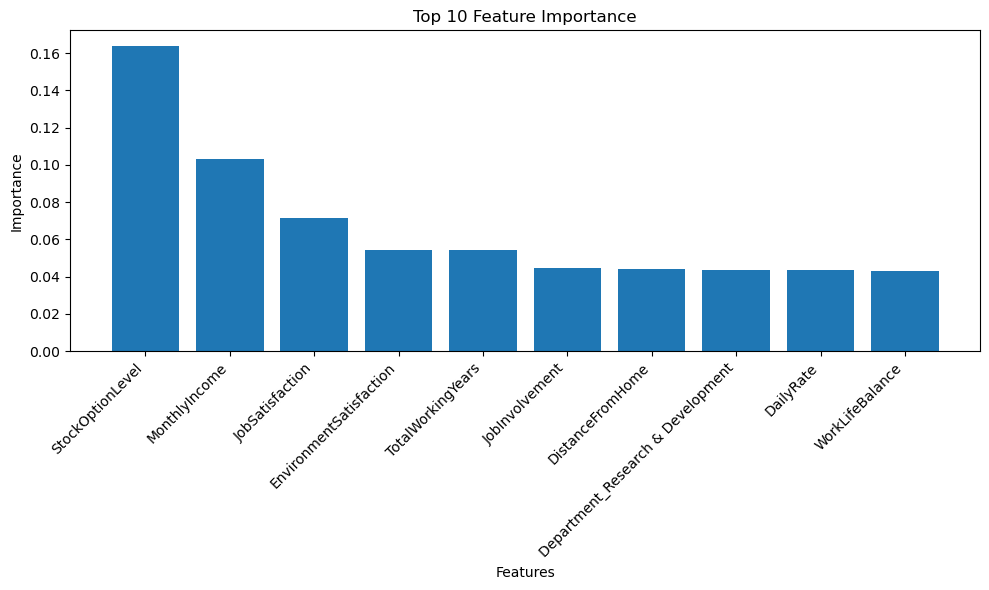

Feature Importance:
StockOptionLevel: 0.1640
MonthlyIncome: 0.1033
JobSatisfaction: 0.0715
EnvironmentSatisfaction: 0.0545
TotalWorkingYears: 0.0543
JobInvolvement: 0.0449
DistanceFromHome: 0.0439
Department_Research & Development: 0.0435
DailyRate: 0.0435
WorkLifeBalance: 0.0429
JobLevel: 0.0429
YearsWithCurrManager: 0.0418
MaritalStatus_Married: 0.0410
Age: 0.0397
TrainingTimesLastYear: 0.0341
OverTime_Yes: 0.0303
Department_Sales: 0.0271
MaritalStatus_Single: 0.0239
YearsAtCompany: 0.0223
YearsInCurrentRole: 0.0182
BusinessTravel_Travel_Frequently: 0.0048
JobRole_Laboratory Technician: 0.0038
JobRole_Manager: 0.0013
JobRole_Sales Representative: 0.0013
JobRole_Manufacturing Director: 0.0009
JobRole_Research Director: 0.0004


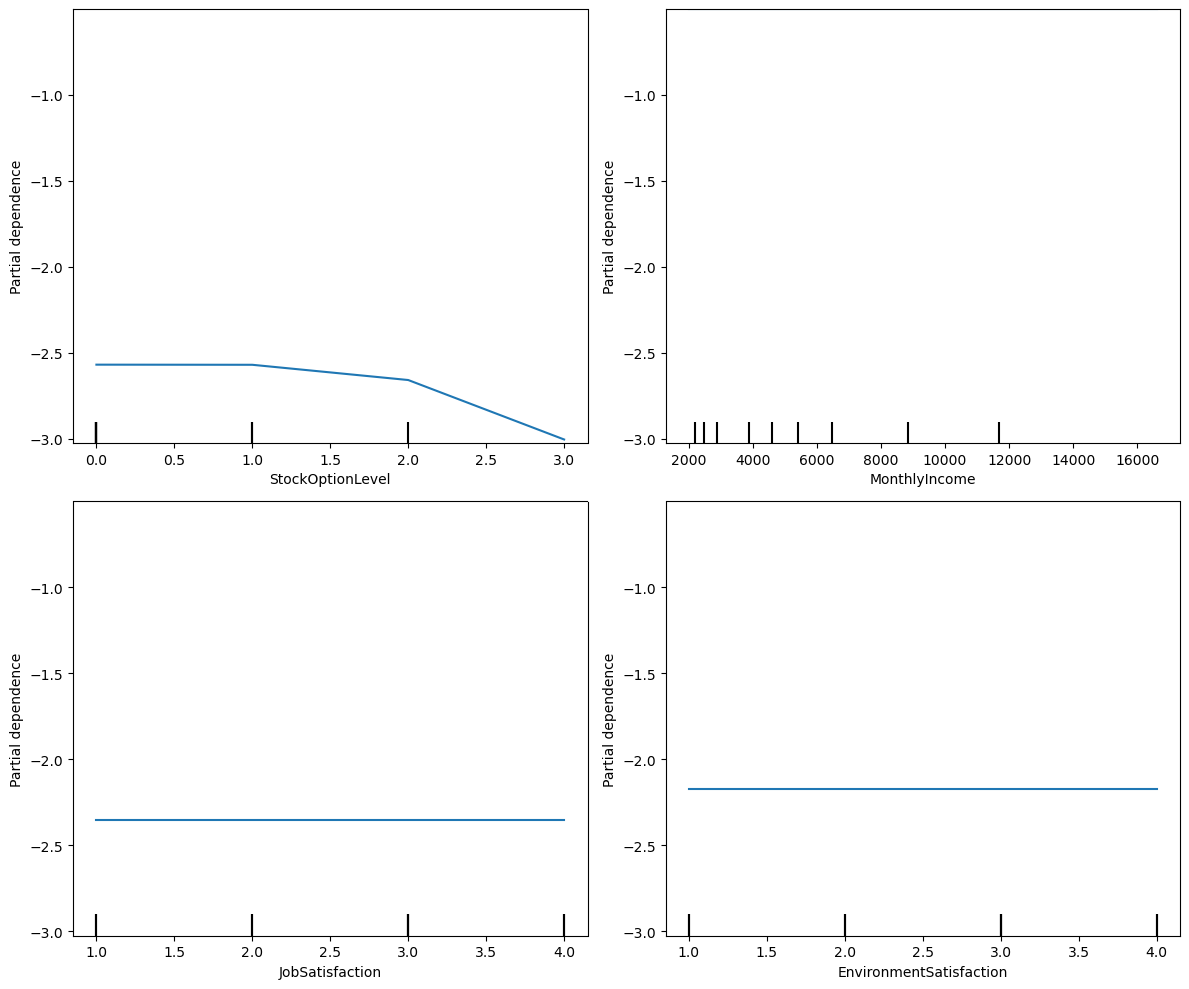


Recommendations based on the model:
1. Focus on the top features identified by the model to address attrition.
2. Use the partial dependence plots to understand how changes in these features affect attrition risk.
3. Develop targeted strategies to address the most influential factors.
4. Regularly monitor these key features and update the model as new data becomes available.
5. Consider conducting further analysis or surveys related to the top features to gain deeper insights.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Assuming 'best_model' is your trained Gradient Boosting model
# and X_test_scaled, X_test (non-scaled version) are available

# 1. Feature Importance
feature_importance = best_model.feature_importances_
feature_names = X_test.columns

# Sort features by importance
feature_importance_sorted = sorted(zip(feature_importance, feature_names), reverse=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar([x[1] for x in feature_importance_sorted[:10]], [x[0] for x in feature_importance_sorted[:10]])
plt.title('Top 10 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print feature importance
print("Feature Importance:")
for importance, name in feature_importance_sorted:
    print(f"{name}: {importance:.4f}")

# 2. Partial Dependence Plots
# Choose top 4 features for partial dependence plots
top_features = [x[1] for x in feature_importance_sorted[:4]]

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
PartialDependenceDisplay.from_estimator(best_model, X_test, top_features, ax=ax.ravel())
plt.tight_layout()
plt.show()

# 3. Recommendations based on findings
print("\nRecommendations based on the model:")
print("1. Focus on the top features identified by the model to address attrition.")
print("2. Use the partial dependence plots to understand how changes in these features affect attrition risk.")
print("3. Develop targeted strategies to address the most influential factors.")
print("4. Regularly monitor these key features and update the model as new data becomes available.")
print("5. Consider conducting further analysis or surveys related to the top features to gain deeper insights.")

### Apply PCA 

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import uniform, randint

# Load the data
data = pd.read_csv('/Users/skyler/Documents/HR_Project/Data/raw_data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Convert categorical variables to numerical
data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})

# Select potentially relevant features based on domain knowledge
relevant_features = [
    'Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
    'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
    'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
    'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
    'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

# Select only the relevant features
X = data[relevant_features]
y = data['Attrition']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Preserve 95% of variance
X_pca = pca.fit_transform(X_scaled)


# Now get the feature names
original_features = X.columns.tolist()

print("Original features after preprocessing:")
print(original_features)

print(f"Number of features after PCA: {X_pca.shape[1]}")

# Use SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the models with their hyperparameter distributions
models = {
    'Logistic Regression': (LogisticRegression(), {
        'C': uniform(0.001, 100),
        'penalty': ['l2']
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5)
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': randint(100, 301),
        'max_depth': randint(3, 8),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5)
    }),
    'SVM': (SVC(), {
        'C': uniform(0.1, 10),
        'kernel': ['rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': randint(3, 10),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': randint(100, 301),
        'learning_rate': uniform(0.01, 0.19),
        'max_depth': randint(3, 8)
    }),
    'Neural Network': (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['tanh', 'relu'],
        'alpha': uniform(0.0001, 0.0099)
    }),
    'Naive Bayes': (GaussianNB(), {
        'var_smoothing': uniform(1e-10, 1e-8)
    })
}

# Perform random search for each model
best_models = {}
for name, (model, param_dist) in models.items():
    print(f"\nPerforming RandomizedSearchCV for {name}...")
    random_search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    best_models[name] = random_search.best_estimator_
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Evaluate the best models on the test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# Find the best overall model
best_model_name = max(best_models, key=lambda name: accuracy_score(y_test, best_models[name].predict(X_test)))
best_model = best_models[best_model_name]

print(f"\nBest overall model: {best_model_name}")
print(f"Best model parameters: {best_model.get_params()}")
y_pred_best = best_model.predict(X_test)
print(f"Best model accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(classification_report(y_test, y_pred_best))

Original features after preprocessing:
['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'MaritalStatus_Married', 'MaritalStatus_Single', 'OverTime_Yes']
Number of features after PCA: 25

Performing RandomizedSearchCV for Logistic Regression...
Best parameters: {'C': 37.45501188

### Saving the model to Pickle Document

In [38]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the data
data = pd.read_csv('/Users/skyler/Documents/HR_Project/Data/raw_data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Convert categorical variables to numerical
data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})

# Select relevant features
relevant_features = [
    'Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
    'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
    'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
    'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
    'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

X = data[relevant_features]
y = data['Attrition']

# Apply dummy encoding
X = pd.get_dummies(X, drop_first=True)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Create a dictionary with all necessary objects
data_dict = {
    'X': X_pca,
    'y': y,
    'scaler': scaler,
    'pca': pca,
    'best_model': best_model,  # Make sure your best_model is defined
    'feature_names': X.columns.tolist()  # Original feature names after dummy encoding
}

# Save to pickle file
with open('pca_svm.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

print("Full data saved to 'employee_attrition_full_data.pkl'")

Full data saved to 'employee_attrition_full_data.pkl'
